In [33]:
import numpy as np
import astropy.units as u
import time
from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))
import poppy
import skimage
from skimage.registration import phase_cross_correlation
import copy
from importlib import reload
import matplotlib.pyplot as plt
import multiprocessing
import astropy.io.fits as fits

import magpyx
from magpyx.utils import ImageStream
import purepyindi
from purepyindi import INDIClient
client0 = purepyindi.INDIClient('localhost', 7624)
client0.start()

from IPython.display import clear_output, display
import subprocess
import glob
from pathlib import Path
import os
cwd = os.getcwd()

from math_module import xp, xcipy, np_array
import utils
import fsm_utils
import cam_utils
from imshows import imshow1, imshow2, imshow3
from matplotlib.patches import Circle

wavelength = 633e-9
fl = 425e-3
fsm_pupil_diam = 7.1e-3
as_per_lamD = (wavelength/fsm_pupil_diam*u.radian).to(u.arcsec)
print(as_per_lamD)

pxscl_lamD = 3.45e-6 / (fl * wavelength/fsm_pupil_diam)
print(1/pxscl_lamD)

zero = np.array([[0,0,0]]).T
v_bias = np.array([[50,50,50]]).T

pxscl_lamD * as_per_lamD

18.389524275269295 arcsec
10.982853643600734


<Quantity 1.6743849 arcsec>

# Setup FSM Interface

In [10]:
fsm_bias_channel = ImageStream('dm00disp00')

In [15]:
fsm_bias_channel.write(v_bias)

In [12]:
fsm_bias_channel.write(zero)

# Setup the camera parameters

In [9]:
reload(cam_utils)
cam = cam_utils.CAM('campupil')


In [8]:
npsf = 50
cam.set_roi(575, 900, npsf, client0)

In [4]:
cam.set_exptime(0.0001, client0)

INFO:utils:Got semaphore index 1.


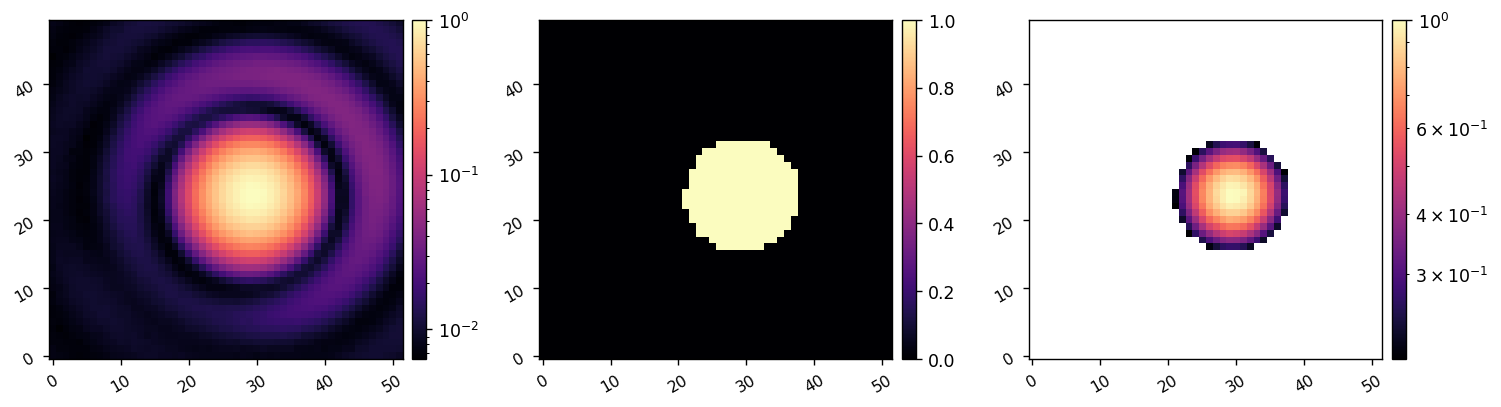

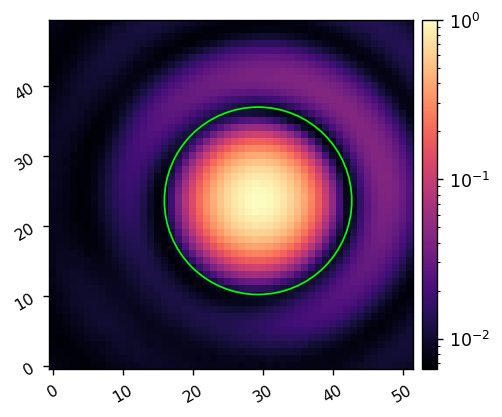

In [6]:
cam.Nframes = 1000
im_bias = cam.snap()

reload(utils)
cen = utils.centroid(im_bias, thresh=0.2, plot=True)
imshow1(im_bias, lognorm=True, patches=[Circle(cen, 1.22/pxscl_lamD, fill=False, color='lime')])


# Setup and record the modulation

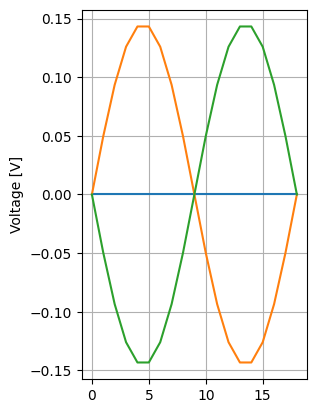

Saved data to:  /opt/MagAOX/calib/dm/fsm/fsm_sine_cube.fits


In [14]:
# Define a sine wave
samps_per_wave = 19
amp = 1*u.arcsec

volt_commands = np.zeros((samps_per_wave, 3, 1))
wave = amp * np.sin(2*np.pi * np.arange(samps_per_wave)/(samps_per_wave-1))
for i in range(samps_per_wave):
    # volt_commands[i] = fsm_utils.get_fsm_volts(tip=wave[i], tilt=0*u.arcsec, dZ=0*u.um)
    volt_commands[i] = fsm_utils.get_fsm_volts(tip=0*u.arcsec, tilt=wave[i], dZ=0*u.um)

plt.subplot(122)
# plt.plot(wave)
plt.plot(volt_commands[:,0])
plt.plot(volt_commands[:,1])
plt.plot(volt_commands[:,2])
plt.ylabel('Voltage [V]')
plt.grid()
plt.show()

utils.save_fits('/opt/MagAOX/calib/dm/fsm/fsm_sine_cube.fits', volt_commands[:-1])


In [17]:
reload(fsm_utils)

t_total = 2
sin_freq = 3

fsm_utils.set_fsm_mod_amp(1, client0, process_name='fsmSineMod')
fsm_utils.set_fsm_mod_rate(sin_freq*18, client0, process_name='fsmSineMod')


In [18]:
fsm_utils.start_fsm_mod(client0, process_name='fsmSineMod')

In [19]:
fsm_utils.stop_fsm_mod(client0, process_name='fsmSineMod')

# Run the experiment.
### Define and make experiment directory if required

In [82]:
# Setup the directories to which the FSM and campupil data will be stored.

sin_freq = 1

fsm_utils.set_fsm_mod_amp(1, client0, process_name='fsmSineMod')
fsm_utils.set_fsm_mod_rate(sin_freq*18, client0, process_name='fsmSineMod')

exp_dir = f'sin-mod-{sin_freq:.2f}'
exp_path = Path(f'{cwd}/data/{exp_dir}')

subprocess.run(['mkdir',str(exp_path)])

mkdir: cannot create directory ‘/home/uasal/Projects/fsm-exps/data/sin-mod-1.00’: File exists


CompletedProcess(args=['mkdir', '/home/uasal/Projects/fsm-exps/data/sin-mod-1.00'], returncode=1)

In [83]:
reload(fsm_utils)
fsm_utils.delete_all_data(exp_path)

In [84]:
reload(fsm_utils)

t_meas = 3

cam.Nframes = 100
frame0 = cam.snap()
utils.save_fits(str(exp_path/'campupil_0.fits'), frame0)

fsm_utils.start_fsm_mod(client0, delay=0.5, process_name='fsmSineMod')
fsm_utils.toggle_telem_fsm(1, client0)
fsm_utils.toggle_telem_campupil(1, client0)

time.sleep(t_meas)

fsm_utils.toggle_telem_campupil(0, client0)
fsm_utils.toggle_telem_fsm(0, client0)
fsm_utils.stop_fsm_mod(client0, process_name='fsmSineMod')



INFO:utils:Got semaphore index 1.


Saved data to:  /home/uasal/Projects/fsm-exps/data/sin-mod-1.00/campupil_0.fits


# Extract and analyze data

In [85]:
# Decompress the .xrif files from the telem_* apps into the desired data directories

telem_cam_path = Path('/opt/MagAOX/telem/campupil/')
telem_fsm_path = Path('/opt/MagAOX/telem/fsm/')

subprocess.run(['xrif2fits','-d',str(telem_cam_path),'-D',exp_path])
clear_output()
subprocess.run(['xrif2fits','-d',str(telem_fsm_path),'-D',exp_path])
clear_output()

In [86]:
cam_data_fnames = sorted(glob.glob(str(exp_path/'campupil*20250130*.fits')))
fsm_data_fnames = sorted(glob.glob(str(exp_path/'dm00disp10*20250130*.fits')))
# cam_data_fnames
# fsm_data_fnames

In [87]:
fsm_start_time = float(fsm_data_fnames[0].split("_")[1][12:-5])/1e9
print(fsm_start_time)

fsm_commands = []
fsm_times = []
for fname in fsm_data_fnames:
    fsm_commands.append(fits.getdata(fname))
    t_hr = float(fname.split("_")[1][8:10])
    t_min = float(fname.split("_")[1][10:12])
    t_sec = float(fname.split("_")[1][12:-5])/1e9
    fsm_times.append( 3600*t_hr + 60*t_min + t_sec )
fsm_commands = np.array(fsm_commands) 
fsm_times = np.array(fsm_times)
fsm_start = fsm_times[0]
rel_fsm_times = fsm_times - fsm_start

print(fsm_start)

45.720638981
78525.720638981


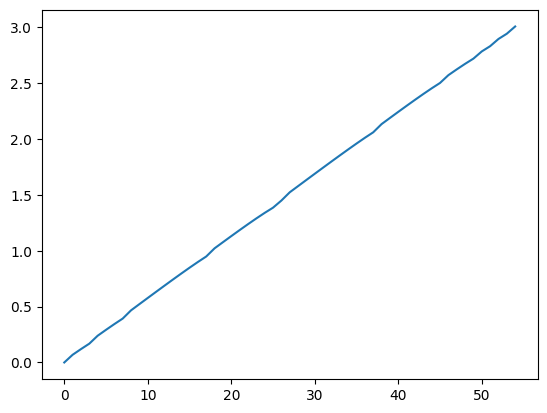

In [88]:
plt.plot(rel_fsm_times)

In [89]:
frames = []
cam_times = []
for fname in cam_data_fnames:
    frames.append(fits.getdata(fname))
    t_hr = float(fname.split("_")[1][8:10])
    t_min = float(fname.split("_")[1][10:12])
    t_sec = float(fname.split("_")[1][12:-5])/1e9
    cam_times.append( 3600*t_hr + 60*t_min + t_sec )
frames = np.array(frames) 
cam_times = np.array(cam_times)
cam_start = cam_times[0]
print(cam_start)
rel_cam_times = cam_times - fsm_start

78525.704805807


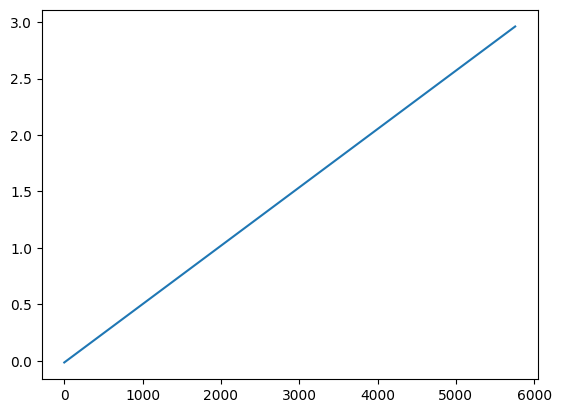

In [90]:
plt.plot(rel_cam_times)

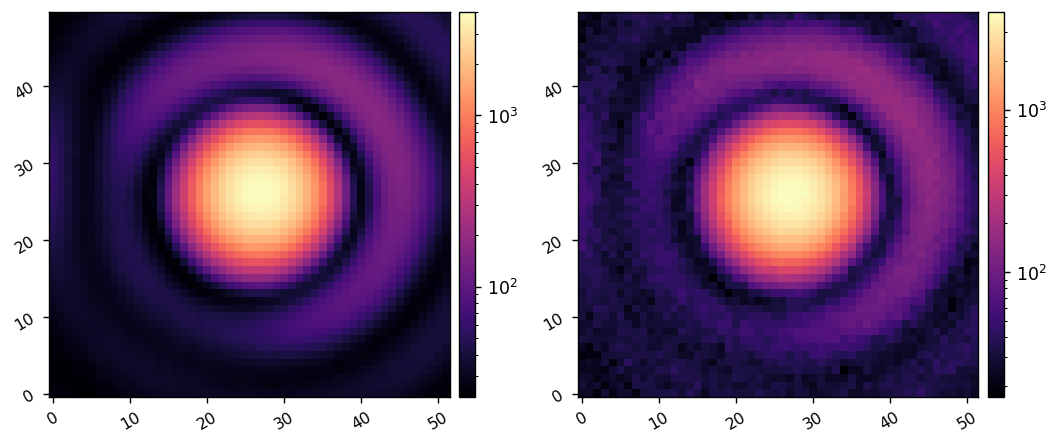

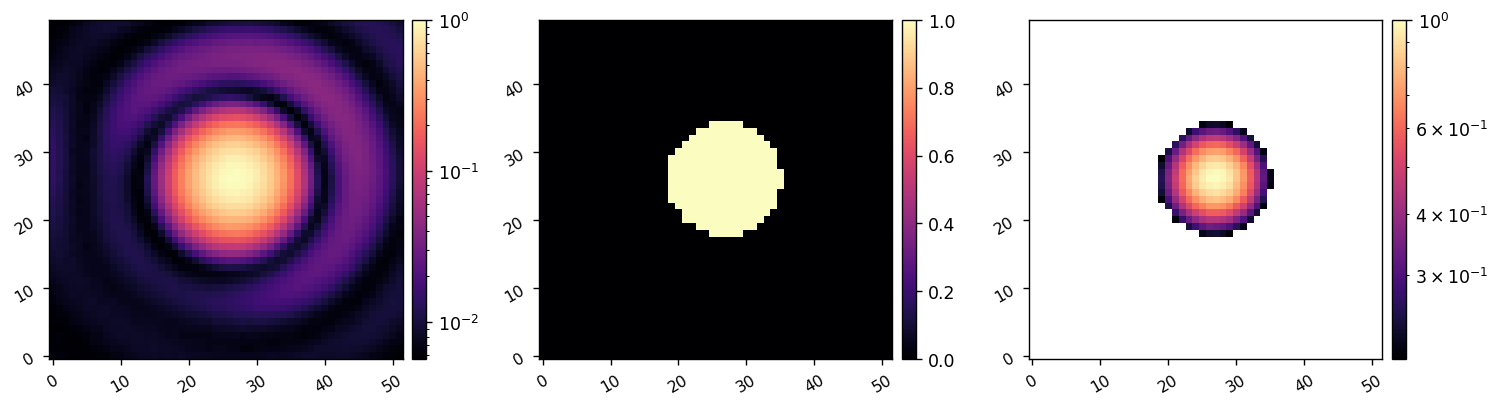

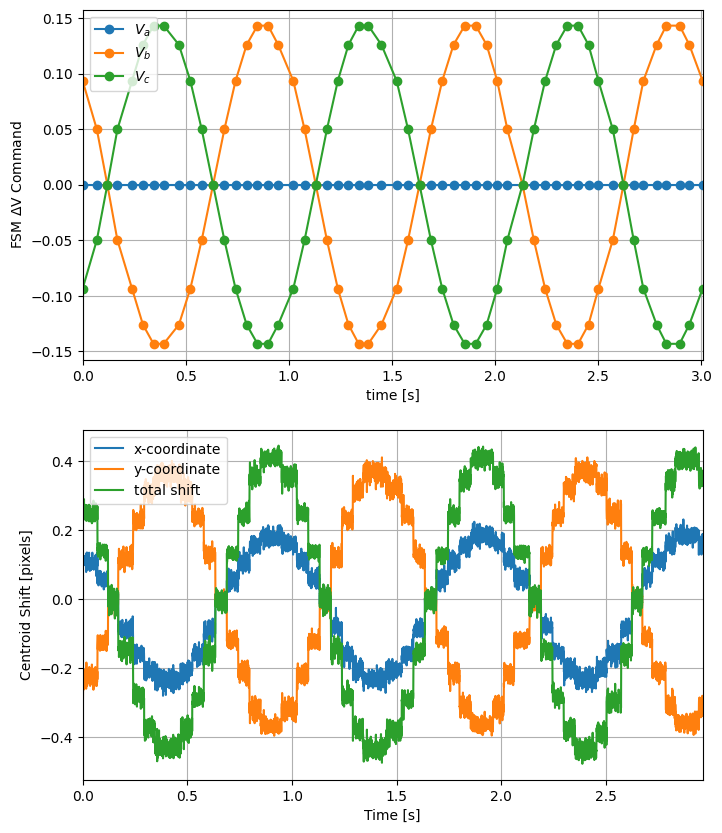

In [99]:
cthresh = 0.2

N = len(cam_data_fnames)
mean_frame = np.mean(frames, axis=0)
imshow2(mean_frame, frames[0], lognorm=True)

shift_pix = []
total_shift_pix = []
frame0 = utils.load_fits(str(exp_path/'campupil_0.fits'))
cen_0 = utils.centroid(frame0.astype(float), thresh=cthresh, plot=True)
for i in range(N):
    cen = utils.centroid(frames[i].astype(float), thresh=cthresh, plot=0)
    shift = cen - cen_0
    shift_pix.append(shift)
    if shift[0]>0 and shift[1]>0:
        total_shift_pix.append(np.sqrt(shift[0]**2 + shift[1]**2))
    elif shift[0]>0 and shift[1]<0:
        total_shift_pix.append(np.sqrt(shift[0]**2 + shift[1]**2))
    elif shift[0]<0 and shift[1]>0:
        total_shift_pix.append(-np.sqrt(shift[0]**2 + shift[1]**2))
    elif shift[0]<0 and shift[1]<0:
        total_shift_pix.append(-np.sqrt(shift[0]**2 + shift[1]**2))
shift_pix = np.array(shift_pix)
total_shift_pix = np.array(total_shift_pix)

shift_as = shift_pix * pxscl_lamD * as_per_lamD # pixels * (lamD/pixel) * (as/lamD)
total_shift_as = total_shift_pix * pxscl_lamD * as_per_lamD

# total_shift_pix = np.sqrt( np.sum( np.square(shift_pix), axis=1) )
# total_shift_as = np.sqrt( np.sum( np.square(shift_as), axis=1) )

fig = plt.figure(figsize=(8,10))
plt.subplot(211)
plt.plot(rel_fsm_times, fsm_commands[:,0], '-o', label='$V_a$')
plt.plot(rel_fsm_times, fsm_commands[:,1], '-o', label='$V_b$')
plt.plot(rel_fsm_times, fsm_commands[:,2], '-o', label='$V_c$')
plt.ylabel('FSM $\Delta$V Command')
plt.xlabel('time [s]')
plt.xlim([0,rel_fsm_times.max()])
# plt.xlim([0, 1])
plt.grid()
plt.legend()

plt.subplot(212)
plt.plot(rel_cam_times, shift_pix[:,0], label='x-coordinate')
plt.plot(rel_cam_times, shift_pix[:,1], label='y-coordinate')
plt.plot(rel_cam_times, total_shift_pix, label='total shift')
# plt.plot(rel_cam_times, shift_as[:,0], label='x-coordinate')
# plt.plot(rel_cam_times, shift_as[:,1], label='y-coordinate')
# plt.plot(rel_cam_times, total_shift_as, label='total shift')
plt.ylabel('Centroid Shift [pixels]')
plt.xlabel('Time [s]')
plt.xlim([0, rel_cam_times.max()])
# plt.xlim([0, 1])
plt.grid()
plt.legend()

plt.show()

[-1.44527398e-01  1.00214283e+00 -8.10389253e-01 -8.81637239e-04]
-1.2559471051708353
[ 1.44527398e-01  1.00214283e+00 -8.10389256e-01  8.81637135e-04]
-1.2559471051708353


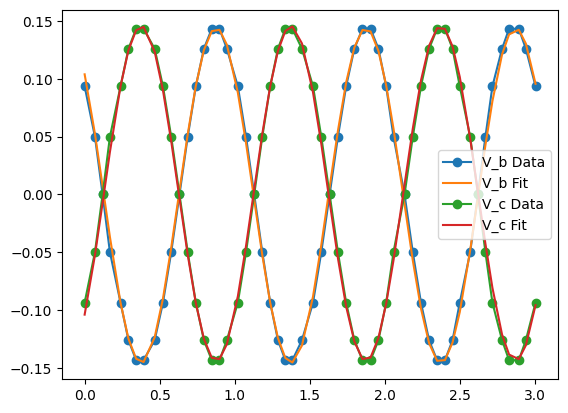

[-0.2086451   1.00243289 -1.00673346 -0.02013033]
-1.0067334560772965
[ 0.36307296  1.00147971 -1.00264292  0.00499707]
-1.0026429199370017


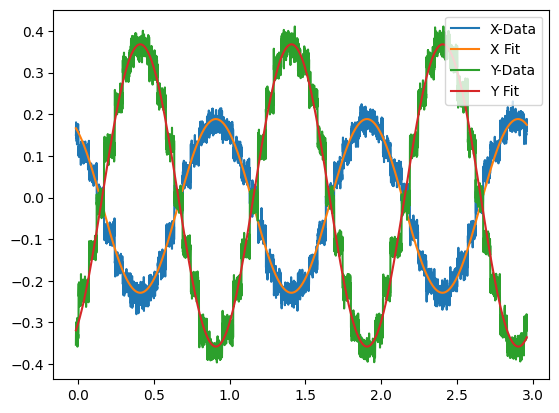

-14.396075518506374


In [93]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def sine_func(x, amp, freq, phase, offset): 
    return amp * np.sin(2*np.pi * freq * x + phase) + offset 

x = rel_fsm_times
data_names = ['V_b', 'V_c']
fsm_data_phase = 0
for i in range(2):
    y = fsm_commands[:,i+1][:,0]

    amp0 = (y.max() - y.min())/2
    freq0 = sin_freq
    offset0 = y.max() - amp0
    # print(amp0, freq0, offset0)

    popt, _ = curve_fit(
        sine_func, 
        x, y, 
        p0=[amp0, freq0, 0, offset0],
        maxfev=100000,
    ) 
    print(popt)
    if phase>np.pi/2:
        phase = popt[2] - np.pi
    elif phase<-np.pi/2:
        phase = popt[2] + np.pi
    print(phase)
    fsm_data_phase += phase/2

    # Plot results
    plt.plot(x, y, '-o', label=data_names[i]+' Data')
    plt.plot(x, sine_func(x, *popt), label=data_names[i]+' Fit')
    plt.legend()
plt.show()

x = rel_cam_times
data_names = ['X', 'Y']
cam_data_phase = 0
for i in range(2):
    y = shift_pix[:,i]

    amp0 = (y.max() - y.min())/2
    freq0 = sin_freq
    offset0 = y.max() - amp0

    popt, _ = curve_fit(
        sine_func, 
        x, y, 
        p0=[amp0, freq0, 0, offset0],
        maxfev=100000,
    ) 
    print(popt)
    phase = popt[2]
    if phase>np.pi/2:
        phase = popt[2] - np.pi
    elif phase<-np.pi/2:
        phase = popt[2] + np.pi
    print(phase)
    cam_data_phase += phase/2

    # Plot results
    plt.plot(x, y, label=data_names[i]+'-Data')
    plt.plot(x, sine_func(x, *popt), label=data_names[i]+' Fit')
    plt.legend()
plt.show()

rel_phase = (fsm_data_phase - cam_data_phase) * 180/np.pi
print(rel_phase)